In [1]:
from src.loadset import create_dataloaders
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
CSV_PATH = "/home/baraa/Desktop/testroch/DSED_strong_label/dataset/metadata/eval/combined_weak_labels.csv"
IMG_DIR = '/home/baraa/Desktop/testroch/DSED_strong_label/dataset/audio/eval/combined_mel'


In [4]:
from src.model_cct import MultiLabelCCT

In [5]:
params = {'embedding_dim': 300, 'learning_rate': 0.000316, 'n_conv_layers': 3, 'num_layers': 5, 'num_heads': 4, 'mlp_ratio': 2.5, 'dropout_rate': 0.3, 'attention_dropout': 0.25}

In [6]:
model = MultiLabelCCT(
        img_size=(192, 668),
        embedding_dim=params['embedding_dim'],
        n_input_channels=3,
        n_conv_layers=params['n_conv_layers'],
        kernel_size=7,
        stride=2,
        padding=3,
        pooling_kernel_size=3,
        pooling_stride=2,
        pooling_padding=1,
        num_layers=params['num_layers'],
        num_heads=params['num_heads'],
        mlp_ratio=params['mlp_ratio'],
        dropout_rate=params['dropout_rate'],
        attention_dropout=params['attention_dropout'],
        num_classes=15,
        positional_embedding='learnable',
    )
model.to(device)

MultiLabelCCT(
  (cct): CCT(
    (tokenizer): Tokenizer(
      (conv_layers): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (1): ReLU()
          (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (1): ReLU()
          (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
        (2): Sequential(
          (0): Conv2d(64, 300, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (1): ReLU()
          (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
      )
    )
    (classifier): TransformerClassifier(
      (attention_pool): Linear(in_features=300, out_features=1, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (blocks

In [7]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {num_params:,} trainable parameters")

The model has 5,228,978 trainable parameters


In [8]:
from src.dynamic_batching import find_optimal_batch_size

In [9]:

# Determine the optimal batch size dynamically
# This is a placeholder for the actual input shape from your dataset
# You might need to load one sample to get the exact dimensions
# Dimensions: (num_channels, height, width)
input_shape = (3, 192, 668) 
initial_batch_size = 500 # A reasonable starting point
optimal_batch_size = find_optimal_batch_size(model, input_shape, initial_batch_size, device , memory_usage_fraction=0.9)

print(f"Using a dynamic batch size of: {optimal_batch_size}")

Available GPU memory: 23.76 GB
Target memory usage: 21.38 GB
Batch size 1000 is too large (OOM). Trying smaller.
Batch size 500 is too large (OOM). Trying smaller.
Batch size 250: Peak memory usage: 17.78 GB
Found optimal batch size 250 within target memory range.
Using a dynamic batch size of: 250


In [10]:
train_loader, val_loader, mlb = create_dataloaders(CSV_PATH, IMG_DIR , batch_size=optimal_batch_size, val_split=0.20 , height=192 , width=668)

Processing 5266 rows from CSV
Found 5266 files in /home/baraa/Desktop/testroch/DSED_strong_label/dataset/audio/eval/combined_mel
First row - fname: 500ms_0.png
First row - labels: ['Frying']
First row - found chunks: 1
Total samples created: 5266


In [11]:
print(mlb.classes_)

['Alarm_bell_ringing' 'Blender' 'Blender_nOff' 'Cat' 'Dishes' 'Dog'
 'Electric_shaver_toothbrush' 'Frying' 'Frying_nOff' 'Frying_nOn_nOff'
 'Running_water' 'Speech' 'Vacuum_cleaner' 'Vacuum_cleaner_nOn'
 'Vacuum_cleaner_nOn_nOff']


In [12]:
all_labels = []
for _, labels in train_loader.dataset:
    all_labels.append(labels)
all_labels = torch.stack(all_labels)
    
    # Calculate positive class frequencies
pos_counts = all_labels.sum(dim=0)
neg_counts = len(all_labels) - pos_counts
    
    # Use a more conservative weighting scheme
# pos_weights = torch.sqrt(neg_counts / (pos_counts + 1e-8))
pos_weights = neg_counts / (pos_counts + 1e-8)

    # Cap the weights to prevent extreme values
pos_weights = torch.clamp(pos_weights, min=1.0, max=10.0)
pos_weights = pos_weights.to(device)

In [13]:
from src.setup_training import setup_training

In [14]:

num_epochs = 60
criterion, optimizer, scheduler = setup_training(model, learning_rate=params['learning_rate'], pos_weights=pos_weights , total_steps_scheduler=len(train_loader) * num_epochs , use_focal_loss = True , T_max=60)

In [15]:
from src.run_epoch_and_eval import train_one_epoch, evaluate, find_optimal_threshold
from IPython.display import clear_output

In [16]:
start_epoch = 0

evlaute outputs:
    metrics = {
        'loss': running_loss / len(val_loader),
        'exact_match_accuracy': exact_match_accuracy.item(),
        'hamming_loss': hamming_loss.item(),
        'f1_macro': f1_macro.item(),
        'f1_micro': f1_micro.item(),
        'jaccard_index': jaccard.item(),
        'element_wise_accuracy': (all_preds == all_labels).float().mean().item()
    }


In [17]:
import matplotlib.pyplot as plt
history = {
    'train_loss': [],
    'val_loss': [],
    'exact_match_accuracy': [],
    'hamming_loss': [],
    'f1_macro': [],
    'f1_micro': [],
    'jaccard_index': [],
    'element_wise_accuracy': [],
    'positive_element_wise_accuracy': [],
    'all_outputs': [],
}

In [18]:
import numpy as np
def plot_history(history , epochs_range):
    plt.figure(figsize=(18, 14))

# Plot Loss
    plt.subplot(2, 4, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch\n\nLoss measures model error. Lower is better.')
    plt.ylabel('Loss')

# Plot Accuracy
    plt.subplot(2, 4, 2)
    plt.plot(epochs_range, history['exact_match_accuracy'], label='Exact Match Accuracy')
    plt.plot(epochs_range, history['element_wise_accuracy'], label='Element-wise Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy Metrics')
    plt.xlabel('Epoch\n\nAccuracy measures correctness. Higher is better.')
    plt.ylabel('Accuracy')

    # Plot F1 Scores
    plt.subplot(2, 4, 3)
    plt.plot(epochs_range, history['f1_macro'], label='F1 Macro')
    plt.plot(epochs_range, history['f1_micro'], label='F1 Micro')
    plt.legend(loc='lower right')
    plt.title('F1 Scores')
    plt.xlabel('Epoch\n\nF1 Score is the harmonic mean of precision and recall. Higher is better.')
    plt.ylabel('F1 Score')

    # Plot Hamming Loss
    plt.subplot(2, 4, 4)
    plt.plot(epochs_range, history['hamming_loss'], label='Hamming Loss')
    plt.legend(loc='upper right')
    plt.title('Hamming Loss')
    plt.xlabel('Epoch\n\nHamming Loss is the fraction of wrong labels. Lower is better.')
    plt.ylabel('Loss')
    plt.subplots_adjust(hspace=0.4)

    # Plot Jaccard Index
    plt.subplot(2, 4, 5)
    plt.plot(epochs_range, history['jaccard_index'], label='Jaccard Index')
    plt.legend(loc='lower right')
    plt.title('Jaccard Index')
    plt.xlabel('Epoch\n\nJaccard Index measures similarity. Higher is better.')
    plt.ylabel('Score')

    plt.subplot(2, 4, 6)

    plt.hist(np.array(history['all_outputs']).flatten(), bins=50, range=(0, 1))
    plt.xlabel("Predicted Probability")
    plt.ylabel("Count")
    plt.title("Distribution of Model Output Probabilities")

    plt.subplot(2, 4, 7)
    plt.plot(epochs_range, history['positive_element_wise_accuracy'], label='Positive Element-wise Accuracy')
    plt.legend(loc='lower right')
    plt.title('Positive Element-wise Accuracy')
    plt.xlabel('Epoch\n\nPositive Element-wise Accuracy measures correctness for positive samples. Higher is better.')
    plt.ylabel('Accuracy')



    plt.tight_layout()
    plt.show()

In [19]:
import copy

# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement before stopping
epochs_no_improve = 0
best_val_loss = float('inf')
best_model_state = None

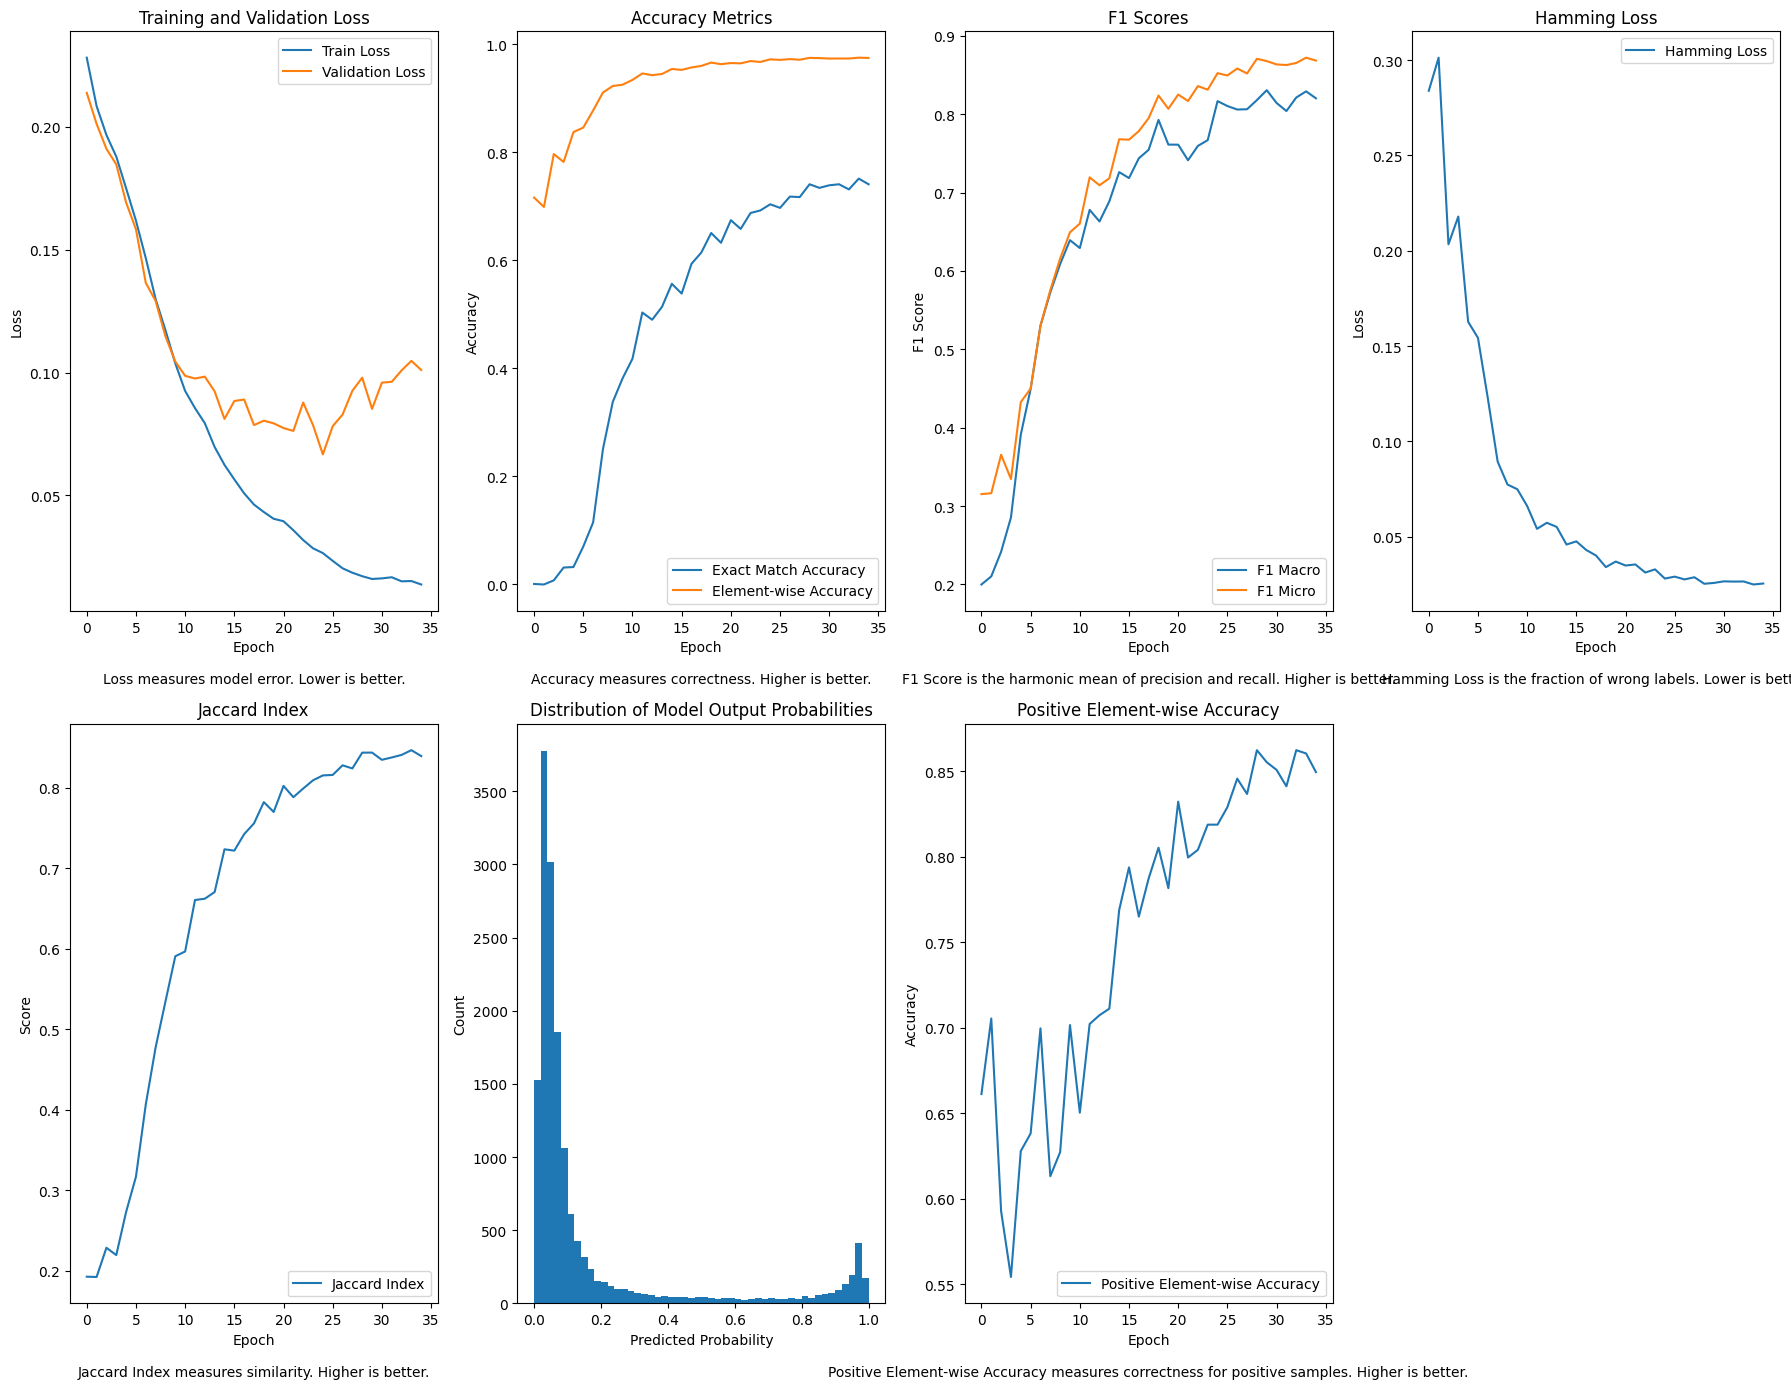

Epoch 35: Validation loss did not improve. Count: 10/10
Early stopping triggered after 10 epochs without improvement.
Training finished. Loading best model state.


In [20]:
for epoch in range(start_epoch, num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    optimal_threshold = find_optimal_threshold(model, val_loader, device)
    metrics = evaluate(model, val_loader, criterion, device , predictions_threshold=optimal_threshold)
    #--- Update history ---
    history['train_loss'].append(train_loss)
    history['val_loss'].append(metrics['loss'])
    history['exact_match_accuracy'].append(metrics['exact_match_accuracy'])
    history['hamming_loss'].append(metrics['hamming_loss'])
    history['f1_macro'].append(metrics['f1_macro'])
    history['f1_micro'].append(metrics['f1_micro'])
    history['jaccard_index'].append(metrics['jaccard_index'])
    history['element_wise_accuracy'].append(metrics['element_wise_accuracy'])
    history['positive_element_wise_accuracy'].append(metrics['positive_element_wise_accuracy'])
    history['all_outputs'] = metrics['all_outputs']
    clear_output(wait=True)
    plot_history(history, range(start_epoch, start_epoch + len(history['train_loss'])))                # --- Early Stopping Logic ---
    val_loss = metrics['loss']
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model state
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"Epoch {epoch + 1}: Validation loss decreased to {val_loss:.4f}. Saving model.")
    else:
        epochs_no_improve += 1
        print(f"Epoch {epoch + 1}: Validation loss did not improve. Count: {epochs_no_improve}/{patience}")
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
        # Load the best model state before stopping
            if best_model_state:
                model.load_state_dict(best_model_state)
                break

# Load the best model state if the loop finished without early stopping
if best_model_state:
    print("Training finished. Loading best model state.")
    model.load_state_dict(best_model_state)

In [21]:
final_checkpoint_path = 'checkpoints/final_model_focal_loss_53ExactMatchAcc.pth'
final_checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'mlb': mlb,
        }
torch.save(final_checkpoint, final_checkpoint_path)

In [ ]:
from src.setup_training import SigmoidFocalLoss
from src.run_epoch_and_eval import evaluate , find_optimal_threshold

if __name__ == '__main__':
    # Define paths
    img_dir = '/home/baraa/Desktop/testroch/DSED_strong_label/mel'
    csv_path = '/home/baraa/Desktop/testroch/DSED_strong_label/weak_labels.csv'
    # checkpoint_path = '/home/baraa/Desktop/testroch/checkpoints/final_model_focal_loss.pth'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create DataLoader
    test_loader, _, mlb = create_dataloaders(csv_path, img_dir, batch_size=50, val_split=0.0)
    
    # Load model

    # Load checkpoint
    # checkpoint = torch.load(checkpoint_path, map_location=device , weights_only=False)
    # model.load_state_dict(checkpoint['model_state_dict'])

    # Create criterion for evaluation (same as used in training)
    # criterion = nn.BCEWithLogitsLoss()
    criterion = SigmoidFocalLoss(alpha=None, gamma=2.0, reduction='mean')
    optimal_threshold = find_optimal_threshold(model, test_loader, device)

    # Evaluate model
    metrics = evaluate(model, test_loader, criterion, device , predictions_threshold=optimal_threshold)
    print("Evaluation Metrics:")
    print(metrics)

Processing 5266 rows from CSV
Found 5266 files in /home/baraa/Desktop/testroch/DSED_strong_label/dataset/audio/eval/combined_mel
First row - fname: 500ms_0.png
First row - labels: ['Frying']
First row - found chunks: 1
Total samples created: 5266
Sample 0 - labels_str: ['Frying']
Sample 0 - label_tensor shape: (15,)
Sample 0 - label_tensor sum: 1
Sample 0 - positive indices: [7]


Finding optimal threshold: 100%|██████████| 90/90 [00:00<00:00, 7683.13it/s]

Best threshold found: 0.6600 with F1-Micro: 0.9328


Sample prediction probabilities: tensor([0.0633, 0.0198, 0.0338, 0.0647, 0.7027, 0.3085, 0.0553, 0.0159, 0.0676,
        0.0368], device='cuda:0')
Max probability in batch: 0.9861
Mean probability in batch: 0.1908
Sample 0 - labels_str: ['Frying']
Sample 0 - label_tensor shape: (15,)
Sample 0 - label_tensor sum: 1
Sample 0 - positive indices: [7]
Evaluation Metrics:
{'loss': 0.01635696348857205, 'exact_match_accuracy': 0.8439043164253235, 'hamming_loss': 0.013267502188682556, 'f1_macro': 0.9327080249786377, 'f1_micro': 0.9328119158744812, 'jaccard_index': 0.9183503985404968, 'element_wise_accuracy': 0.9867324829101562, 'positive_element_wise_accuracy': 0.9324532151222229, 'all_outputs': array([[0.06329822, 0.01984658, 0.03384916, ..., 0.03046765, 0.057934  ,
        0.0175219 ],
       [0.02970547, 0.08439407, 0.0414111 , ..., 0.0602052 , 0.02388015,
        0.05237935],
       [0.08386051, 0.0560092 , 0.04525867, ..., 0.0620486 , 0.01915255,
        0.0708452 ],
       ...,
       [0.